# Avaliação do modelo YOLOv8

Este notebook carrega um modelo YOLOv8 treinado, executa a validação no *split* escolhido (val/test/train) e gera as métricas e gráficos (PR curve, Confusion Matrix, etc.).

⚠️ **Pré‑requisitos**: ter o pacote `ultralytics` instalado e o ficheiro de pesos `.pt`, bem como o `data.yaml` correspondente.

In [1]:
!pip install ultralytics

In [8]:
# ⬅️ Edite aqui os caminhos antes de correr
# Caminho relativo (a partir do local onde está o notebook)
weights_path = 'model/y8s_finetune15/weights/best.pt'  # caminho para .pt treinado
data_yaml     = 'chestx_det10_yolo/data.yaml'                  # caminho para data.yaml
split         = 'val'                               # 'train', 'val' ou 'test'
batch_size    = 16
img_size      = 640


In [9]:
import pandas as pd
from ultralytics import YOLO


model = YOLO(weights_path)

results = model.val(
    data=data_yaml,
    split=split,
    imgsz=img_size,
    batch=batch_size,
    conf=0.001,         # recolhe todas as detecções
    iou=0.7,            # IoU para NMS
    save_json=True,     # guarda detecções em formato COCO
    plots=True          # gera gráficos automaticamente
)

Ultralytics 8.3.162  Python-3.12.7 torch-2.7.1+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.30.2 ms, read: 261.2319.5 MB/s, size: 382.7 KB)


val: Scanning C:\Users\lynxv\Desktop\GitHub\projecto-apvc\project-apvc\chestx_det10_yolo\labels\val... 542 images, 83 backgrounds, 0 corrupt: 100%|██████████| 542/542 [00:02<00:00, 212.36it/s]

val: New cache created: C:\Users\lynxv\Desktop\GitHub\projecto-apvc\project-apvc\chestx_det10_yolo\labels\val.cache



c:\Users\lynxv\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [02:18<00:00,  4.09s/it]


                   all        542       1476      0.562      0.446      0.442      0.224
           Atelectasis         48         51      0.464       0.49      0.381      0.136
         Calcification         38         67      0.556      0.358      0.368      0.135
         Consolidation        289        446      0.645      0.599      0.602      0.288
              Effusion        252        372      0.566      0.581      0.546      0.229
             Emphysema         39         66      0.844      0.573      0.716      0.573
              Fibrosis         82        120      0.546      0.467      0.434      0.228
              Fracture         76        115       0.57       0.38      0.379      0.131
                  Mass         30         31      0.546      0.452      0.436      0.245
                Nodule         77        166       0.45      0.325      0.304       0.15
          Pneumothorax         35         42      0.432      0.238      0.251      0.123
Speed: 1.1ms preproce

In [12]:
print('\n📈  Resumo de métricas globais')
for k, v in results.stats.items():
    if isinstance(v, list):
        formatted = ', '.join(f'{x:.4f}' if isinstance(x, (int, float)) else str(x) for x in v)
        print(f'{k}: [{formatted}]')
    else:
        print(f'{k}: {v:.4f}')


# 💾  COPIAR FICHEIROS ÚTEIS -----------------------------------------------
import shutil, pathlib
out_dir = pathlib.Path(results.save_dir)
shutil.copy(out_dir / 'confusion_matrix.png',       'confusion_matrix.png')
shutil.copy(out_dir / 'confusion_matrix_normalized.png',
            'confusion_matrix_norm.png')
shutil.copy(out_dir / 'results.csv',                'metrics_per_class.csv')

print('\n✅  Ficheiros guardados:')
print('  • confusion_matrix.png')
print('  • confusion_matrix_norm.png')
print('  • metrics_per_class.csv')



📈  Resumo de métricas globais
tp: []
conf: []
pred_cls: []
target_cls: []
target_img: []


FileNotFoundError: [Errno 2] No such file or directory: 'runs\\detect\\val4\\results.csv'

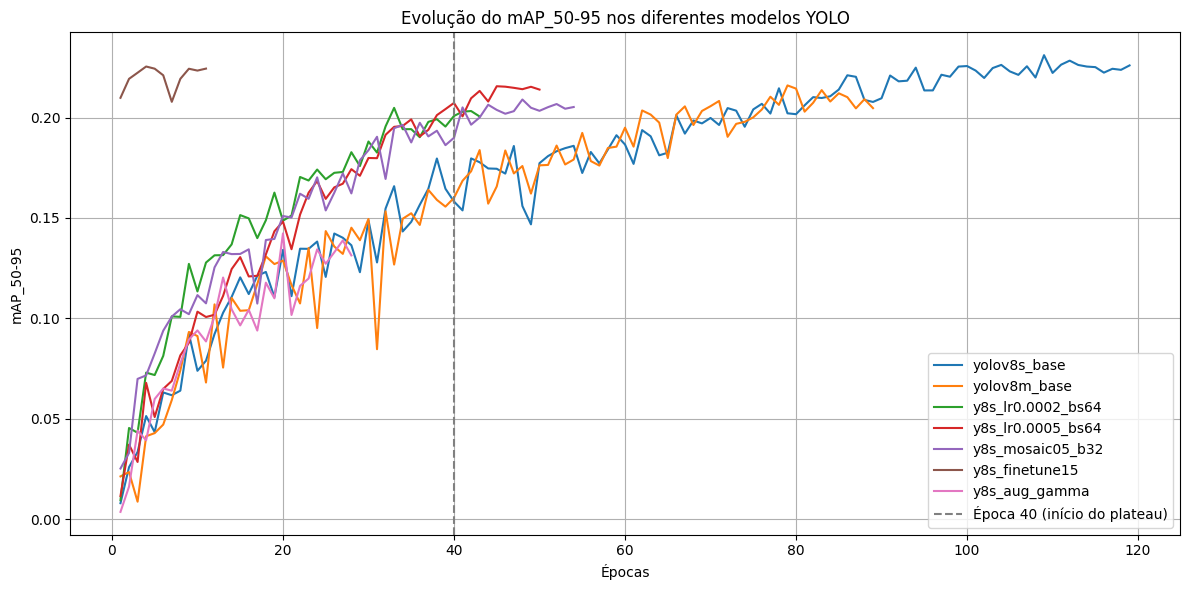

In [ ]:
# YOLO runs comparison - mAP50-95 analysis
import os
import pandas as pd
import matplotlib.pyplot as plt

# Diretório onde estão os runs
base_path = '/content/drive/MyDrive/YOLO/runs_workflow'  # <-- ALTERAR para o caminho real

# Procurar pastas com resultados
runs_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

# Inicializar estrutura para armazenar resultados
all_results = {}

# Ler results.csv de cada modelo
for run in runs_dirs:
    csv_path = os.path.join(base_path, run, 'results.csv')
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        all_results[run] = df
    else:
        print(f'[Aviso] Não encontrado: {csv_path}')

# Plotar comparação do mAP50-95
plt.figure(figsize=(12, 6))
for run, df in all_results.items():
    if 'metrics/mAP50-95(B)' in df.columns:
        plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label=run)

plt.axvline(40, color='gray', linestyle='--', label='Época 40 (início do plateau)')
plt.title('Evolução do mAP_50-95 nos diferentes modelos YOLO')
plt.xlabel('Épocas')
plt.ylabel('mAP_50-95')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
